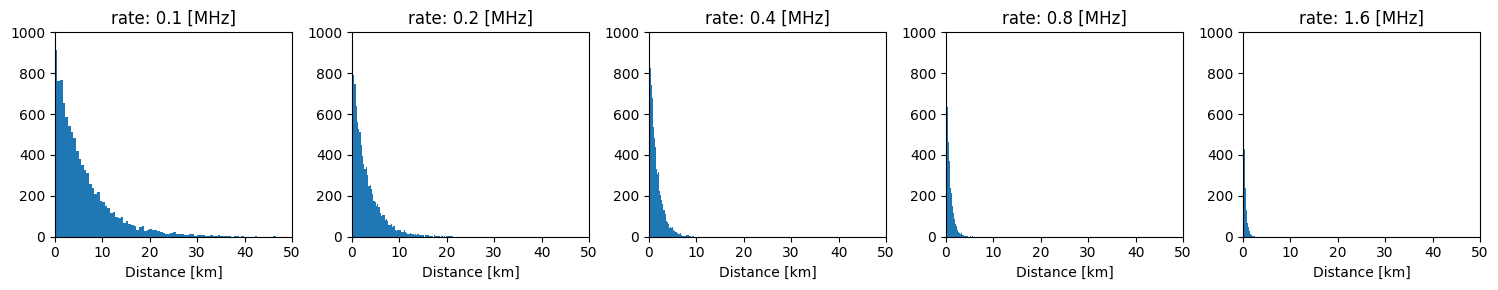

In [3]:
import numpy as np
import scipy.constants as con
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,5,  figsize=(15, 3))
for i,ax in enumerate(axs):
    rate = 0.1e6 * 2**i
    dts = np.random.default_rng().exponential(scale=1/rate, size=10000)
    ax.hist(con.speed_of_light * dts * 2 / 1000,bins=100)
    ax.set_xlabel('Distance [km]')
    ax.set_xlim([0,50])
    ax.set_ylim([0,1000])
    ax.set_title(f'rate: {rate/1e6} [MHz]')
plt.tight_layout()

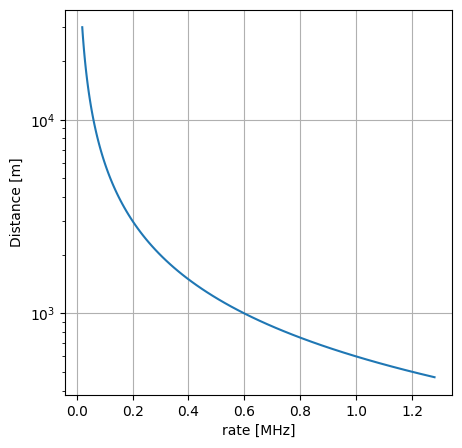

In [4]:

rates = [0.01e6 * 2**i for i in np.linspace(1,7,100)]
fig, axs = plt.subplots(1,1,  figsize=(5, 5))
axs.plot(np.array(rates) / 1e6, [con.speed_of_light * 2 / rate for rate in rates])
axs.set_ylabel('Distance [m]')
axs.set_yscale('log')
axs.set_xlabel('rate [MHz]')
axs.grid()

In [5]:
from scipy.stats import binom, norm, truncnorm

pos = 10
values = [i*10 for i in range(101)]

loc = values.index(pos)/len(values)
a, b = 0-loc,1-loc
x = np.linspace(truncnorm.ppf(0.00000001, a, b),
                truncnorm.ppf(0.99999999, a, b), len(values))

std = 0.1
probs = truncnorm.pdf(x, a/std, b/std, scale=std, loc=loc)/len(x)
err = 1-sum(probs)
probs[probs.argmax()] += err
samples = np.random.choice(values, size=100000 , p=probs)

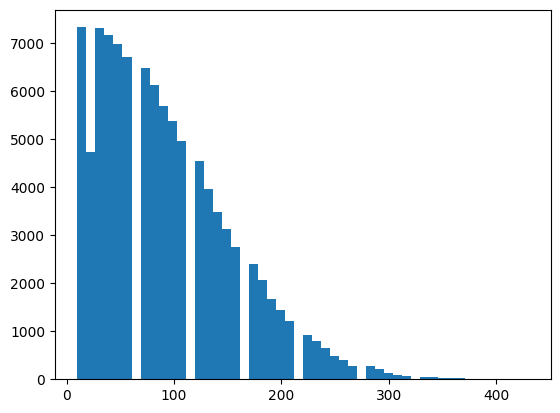

In [6]:
plt.hist(samples, bins=50)
plt.show()

In [7]:
probs.argmax()

1

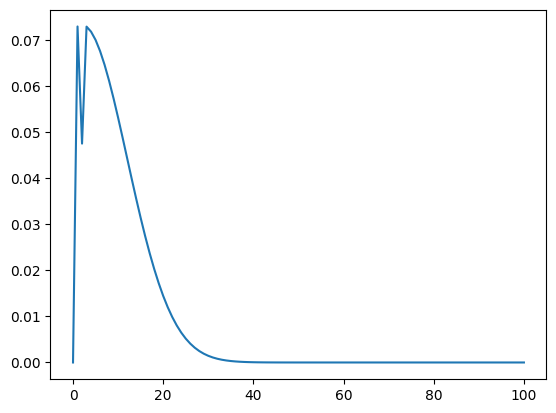

In [8]:
plt.plot(probs)

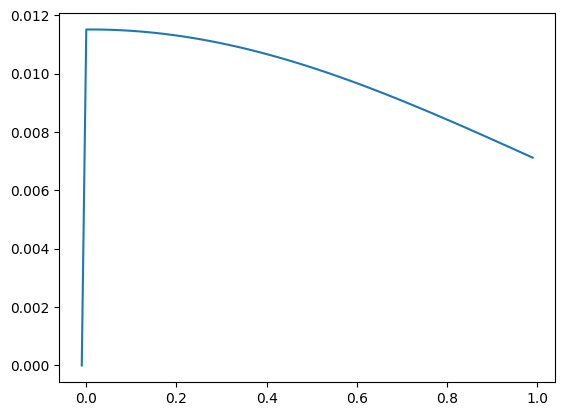

In [9]:
plt.plot(x,truncnorm.pdf(x, a, b, loc=loc)/len(x))


In [10]:
bulk = sum((truncnorm.pdf(x, a, b, loc=loc)/len(x))[:-1])
1-bulk

0.0148446397830313

In [11]:
(truncnorm.pdf(x, a, b, loc=loc)/len(x))[-1]

0.007125333337331013

In [12]:
import torch.multiprocessing as mp
import time

with mp.Pool(processes=10) as pool:
    y_temp = pool.map(np.sin, [i for i in np.linspace(2*np.pi,0,10000)])
    pool.close()
    pool.join()

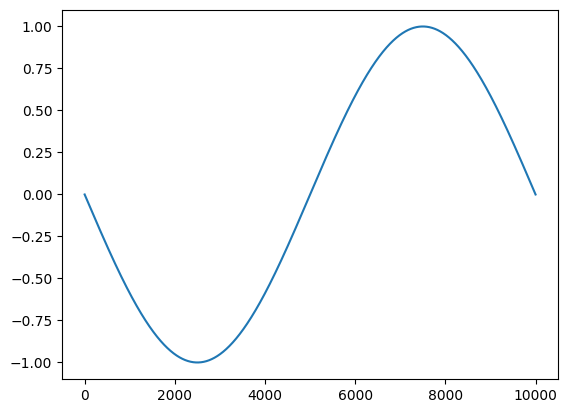

In [13]:
plt.plot(y_temp)

In [3]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses
Fr = 0.81 # min threshold fidelity

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def D_H(w1,w2, transform=False):
    e2ew = np.prod([w1, w2]) 

    F = (3*e2ew+1)/4 if transform else e2ew
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2, transform=False): 
    val = np.log(R*D_H(w1,w2, transform))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 + (4*Fr-1)/3 - np.prod([w1,w2])

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**i for i in np.linspace(1,9.6,100)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)) # transmissivity
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,100), (0.91,1.), (0.91,1.)), method='L-BFGS-B')
    rate, fidels, fidelu = sol.x
    U = 2*U_D(rate, fidels, fidelu, transform=True)

    res['Server link'].append(fidels)
    res['User link'].append(fidelu)
    res['Utility'].append(U)
    res['Fidelity'].append(fidels*fidelu)
    res['Rate'].append(2*rate)
    res['Distance [km]'].append(2*i)
df_res = pd.DataFrame.from_records(res)


In [4]:
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')

Text(0, 0.5, 'Fidelity')

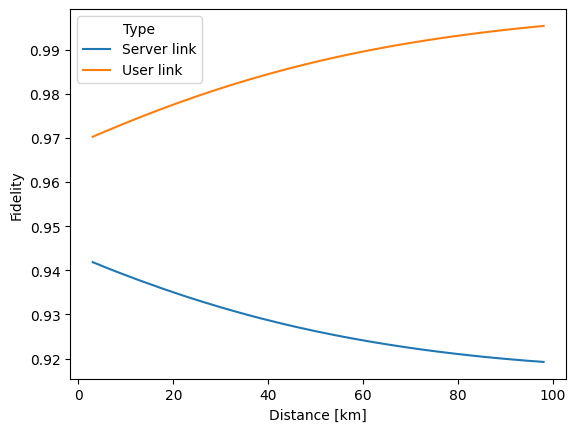

In [5]:
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')

<Axes: xlabel='Distance [km]', ylabel='Utility'>

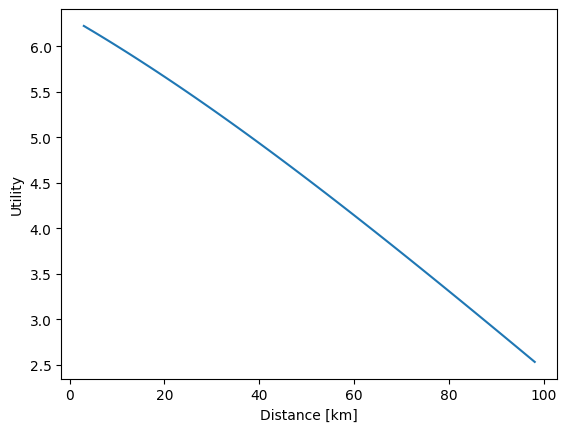

In [6]:
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True)

(0.7, 1.0)

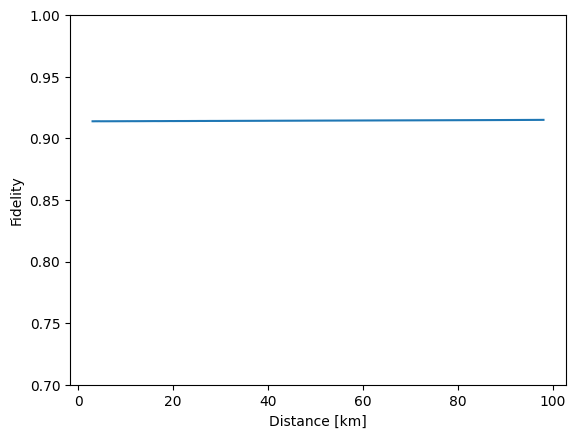

In [7]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True)
plt.ylim([0.7,1])

<Axes: xlabel='Distance [km]', ylabel='Rate'>

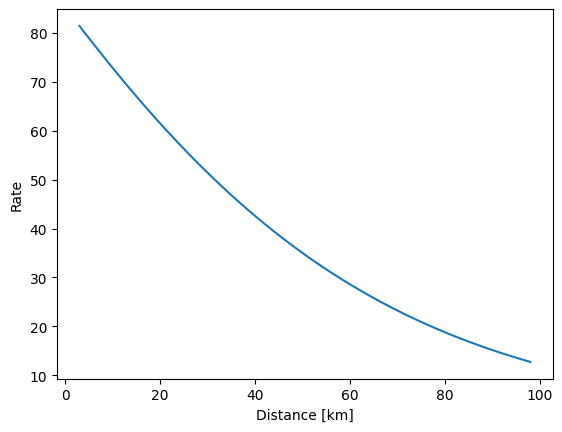

In [8]:
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True)

In [71]:
import pickle
with open('examples/Sur_qswitch_nleafnodes3_0.05h_objective-servernode_SEED42_02-06-2024_11:50:35.pkl', 'rb') as file:
    df = pickle.load(file)

In [72]:
font = 20
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font
})

Text(0.5, 0, 'Distance [km]')

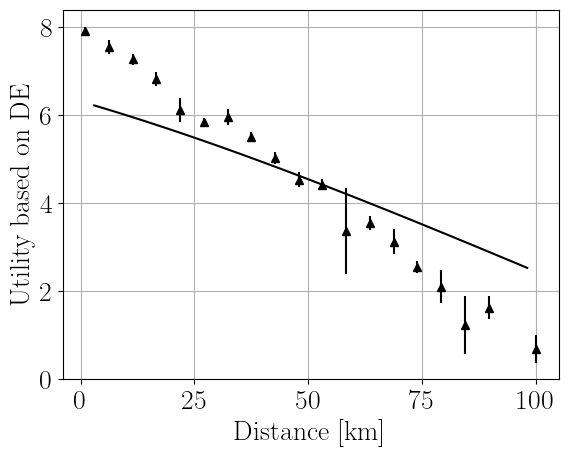

In [73]:
plt.errorbar(df['server_distance'], df['Utility'],df['Utility_std'], fmt='^', color='black')
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True, color='black')
plt.grid()
plt.ylabel('Utility based on DE')
plt.xlabel('Distance [km]')

Text(0, 0.5, 'Fidelity')

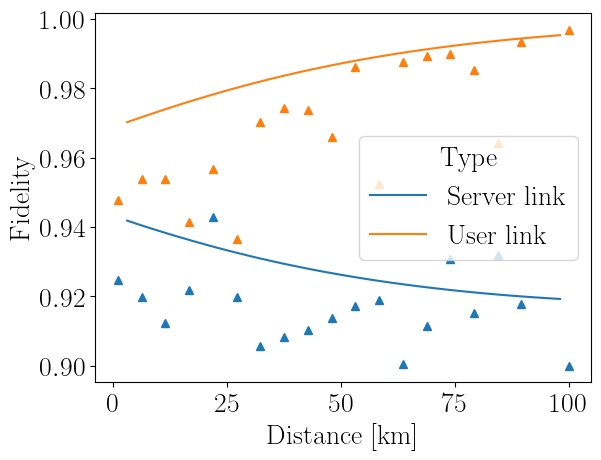

In [74]:
plt.plot(df['server_distance'], 1-df['bright_state_server'], '^')
plt.plot(df['server_distance'], 1-df['bright_state_user'], '^')
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')
plt.xlabel('Distance [km]')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Rate [Hz]')

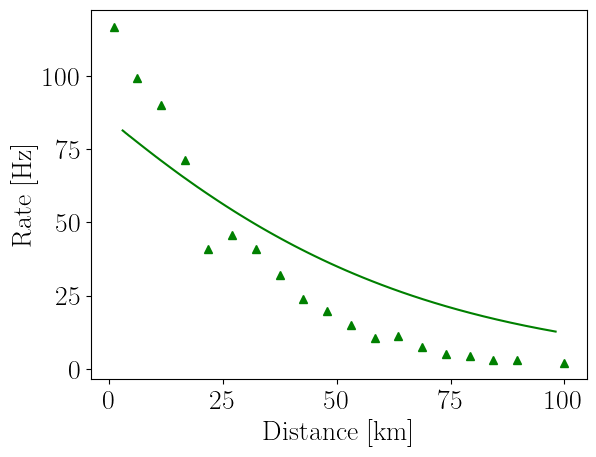

In [75]:
plt.plot(df['server_distance'], df['Rate'], '^' , color='g')
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True, color='g')
plt.xlabel('Distance [km]')
plt.ylabel('Rate [Hz]')

In [52]:
df

,bright_state_server,bright_state_user,Iteration,Fidelity,Rate,Utility,Utility_std,server_distance
0,0.053751,0.040118,2,F_leaf_node_2 0.916759 F_leaf_node_1 0.9...,102.320,7.637463,0.100432,1.000000
1,0.064844,0.052147,5,F_leaf_node_2 0.891903 F_leaf_node_1 0.8...,96.556,6.950676,0.154354,6.210526
2,0.079360,0.046365,3,F_leaf_node_2 0.880541 F_leaf_node_1 0.8...,93.876,6.680915,0.188603,11.421053
3,0.069155,0.025872,4,F_leaf_node_2 0.911212 F_leaf_node_1 0.9...,64.312,6.653479,0.117537,16.631579
4,0.063352,0.032658,10,F_leaf_node_2 0.911983 F_leaf_node_1 0.9...,46.540,5.994588,0.173174,21.842105
5,0.053897,0.020155,11,F_leaf_node_2 0.931602 F_leaf_node_1 0.9...,30.964,5.642679,0.278669,27.052632
6,0.078030,0.015520,4,F_leaf_node_2 0.914279 F_leaf_node_1 0.9...,35.676,5.480828,0.188426,32.263158
7,0.083441,0.012019,5,F_leaf_node_2 0.913444 F_leaf_node_1 0.9...,29.428,5.099302,0.183473,37.473684
8,0.062322,0.009041,4,F_leaf_node_2 0.936338 F_leaf_node_1 0.9...,18.408,4.545808,0.274670,42.684211
9,0.086396,0.007865,14,F_leaf_node_2 0.918673 F_leaf_node_1 0.9...,19.036,4.296829,0.206613,47.894737


In [54]:
import numpy as np
test = np.array(range(5))
list1 = ['0','1','2','3','4']
list2 = ['0', 'hi3', 'leaf_1']

test[~[any([x in y for y in list2]) for x in list1]]

TypeError: bad operand type for unary ~: 'list'

In [63]:
any(df_plot.columns.str.contains('Rate'))

True

In [70]:
np.mean([np.nan, 1 ,2])

nan

In [87]:
np.min([[1,2,3,np.nan],[1,2,2,1]], nan=0)

TypeError: min() got an unexpected keyword argument 'nan'

In [84]:
np.array([[1,2,3,4],[1,2,2,1]]).sum(axis=1)

array([10,  6])

In [117]:
np.exp(np.nan)

nan

In [100]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Generate a DataFrame with random numbers
df = pd.DataFrame(np.random.rand(10, 4), columns=['A', 'B', 'C', 'D'])

# Introduce NaN values at random positions
for _ in range(5):  # Number of NaNs to introduce
    # Randomly choose a row and column index to replace with NaN
    ix = np.random.choice(df.index)
    col = np.random.choice(df.columns)
    df.at[ix, col] = np.nan

print(df)

          A         B         C         D
0  0.374540  0.950714  0.731994       NaN
1  0.156019  0.155995  0.058084       NaN
2  0.601115       NaN  0.020584  0.969910
3  0.832443  0.212339  0.181825  0.183405
4  0.304242  0.524756  0.431945  0.291229
5  0.611853  0.139494  0.292145  0.366362
6  0.456070  0.785176  0.199674       NaN
7  0.592415  0.046450       NaN  0.170524
8  0.065052  0.948886  0.965632  0.808397
9  0.304614  0.097672  0.684233  0.440152


In [105]:
df.isna().sum().sum()

5

/var/folders/d5/3r233ss93fv98nxsrp4wy_hc0000gn/T/ipykernel_45329/1073725081.py:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(T, prog="twopi")


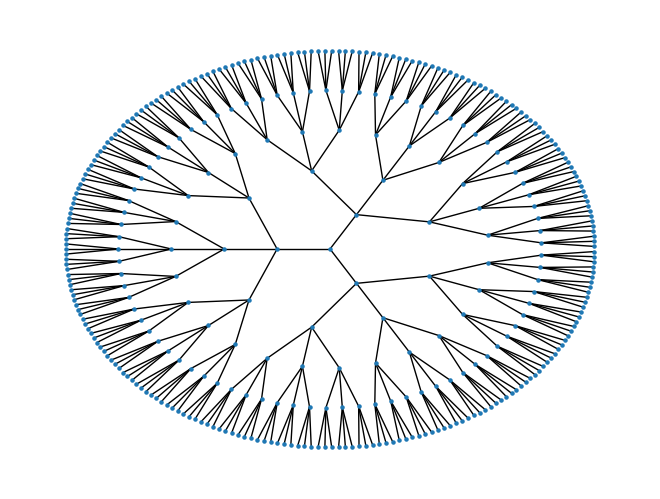

In [78]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(3, 5)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, node_size=5)
plt.show()


In [31]:
!pip install pydot